In [1]:
import cmocean as cmo
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset
import seaborn as sns

In [2]:
# Load output
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output'
levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)

In [3]:
def plot_spectrogram2(ax,timeseries, X, col, lab,kind='linear', title='', xlim=[0,40]):
    samp_freq = 1/600 # 10 min data
    
    freq_per, Pxx_den_per = signal.periodogram(timeseries, samp_freq, detrend='constant', scaling='density')
        
    if kind == 'semilog':
        ax.semilogy(freq_per*(86400), 1E6*Pxx_den_per/(1e4*86400),color=col, alpha=1, label=lab, linewidth=2)
    elif kind=='linear':
        ax.plot(freq_per*(86400), 1E6*Pxx_den_per/(1e4*86400),color=col, alpha=1,linewidth=2)  
    else:
        raise Exception("%s is not a valid value for kind" %kind)
    #print((freq_per[1:]-freq_per[:-1])*86400)
    ax.legend()
    ax.set_xlim(xlim)
    ax.set_ylabel(r'PSD (10$^{-6}$ m$^2$cpd$^{-1}$)', labelpad=0.1)
    ax.set_xlabel('Frequency (cpd)', labelpad=0.1)
    ax.set_title(title)
    return ax
def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    #return u[..., 1:, :], v[..., 1:]
    return u, v


In [4]:
# Load grid variables and mask
LAT = ds['YC'][:].data
LON = ds['XC'][:].data-360
lat = ds.YC[:,0].data
lon = ds.XC[0,:].data-360

nx = len(lon)
ny = len(lat)

# centers mask
hFacC = ds['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
depth = ds['Depth'][:]

Text(0.05, 0.9, 'l')

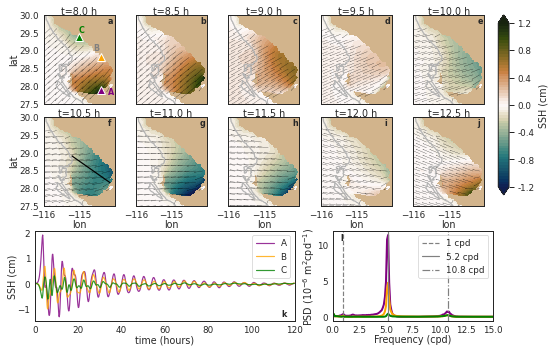

In [82]:
sns.set_context('paper')
sns.set_style('white')

cmap=cmo.cm.tarn_r
time = np.arange(0,720)*600
vmin = -1.2
vmax = 1.2
levs = np.linspace(vmin,vmax,60)
lon_inds = [428+59, 428+59, 428+20]
lat_inds = [61+3, 133, 175]
colors = ['purple', 'orange','green']
llon, llat = np.meshgrid(lon,lat)
  
fig = plt.figure(figsize=(7.48,5))
gs1 = gridspec.GridSpec(2,5)
gs1.update(left=0.05,bottom=0.42, top=0.95, wspace=0.05, hspace=0.15)
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs1[0,1])
ax3 = plt.subplot(gs1[0,2])
ax4 = plt.subplot(gs1[0,3])
ax5 = plt.subplot(gs1[0,4])
ax6 = plt.subplot(gs1[1,0])
ax7 = plt.subplot(gs1[1,1])
ax8 = plt.subplot(gs1[1,2])
ax9 = plt.subplot(gs1[1,3])
ax10 = plt.subplot(gs1[1,4])

axs=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
panel = ['a','b','c','d','e','f','g','h','i','j']
for tt, ax, pan in zip(range(48, 79, 3),axs, panel):
    ax.set_xlim(-116, -114)
    ax.set_ylim(27.5, 30)
    ax.set_facecolor('tan')

    eta = ds['ETAN'][tt,:,:]
    pc = ax.contourf(lon,lat, 
                     np.ma.masked_array(eta*100,mask=mask[0,:,:]),
                     levels=levs,
                     cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
    ax.set_title('t=%1.1f h'%(time[tt]/3600), pad=0.3)
    ax.set_aspect(1)
    ax.contour(lon,lat, np.ma.masked_array(depth,mask=mask[0,:,:]), levels=[250],colors='0.7')
    ax.text(0.9,0.9,pan, transform=ax.transAxes, fontweight='bold', fontsize=8)
    
    uu = ds['UVEL'][tt,0,:200,300:].data
    vv = ds['VVEL'][tt,0,:200,300:].data
    #u, v = unstagger(uu,vv)
    sp = 12  
    ax.quiver(llon[:200:sp,300::sp],llat[:200:sp,300::sp],
              np.ma.masked_array(uu, mask=mask[0,:200,300:])[::sp,::sp],
              np.ma.masked_array(vv, mask=mask[0,:200,300:])[::sp,::sp],
              scale=1)

ax.set_aspect(1)
ax.set_xlim(-116, -114)
ax.set_ylim(27.5, 30)
    

cbar_ax = fig.add_axes([0.91, 0.45, 0.02, 0.5]) 
cb = fig.colorbar(pc,
                  cax=cbar_ax, orientation='vertical', 
                  format='%1.1f', label='SSH (cm)', pad=0,
                  extend='both', ticks=[-1.2,-0.8,-0.4,0,0.4,0.8,1.2])

for jj, col in zip(range(len(lon_inds)), colors):
    ax1.plot(lon[lon_inds[jj]],lat[lat_inds[jj]],'^',color=col, markeredgecolor='w', markersize=8)
ax1.text(0.5,0.8,'C',color=colors[2], fontsize=8, fontweight='bold',transform=ax1.transAxes)
ax1.text(0.7,0.6,'B',color='0.5',transform=ax1.transAxes,fontsize=8, fontweight='bold')
ax1.text(0.9,0.1,'A',color=colors[0],transform=ax1.transAxes,fontsize=8, fontweight='bold')

#ax6.plot([-115.07,-115.07],[27.83,29.4],color='gold')
ax6.plot([-115.2,-114.13],[28.9,28.15],color='k')


for ax in [ax1, ax6]:
    ax.set_ylabel('lat', labelpad=0.1)
for ax in [ax6,ax7,ax8,ax9, ax10]:
    ax.set_xlabel('lon', labelpad=0.1)
for ax in [ax2,ax3,ax4,ax5,ax7,ax8,ax9,ax10]:
    ax.set_yticks([])
for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_xticks([])
for ax in [ax1,ax6]:    
    ax.yaxis.set_tick_params(pad=-0.2)
for ax in [ax6,ax7,ax8,ax9,ax10]:
    ax.set_xticks([-116,-115])
    ax.xaxis.set_tick_params(pad=0)

# ------- time series ----------
gs2 = gridspec.GridSpec(1, 5, wspace=0.62)
gs2.update(left=0.05,bottom=0.1, top=0.35, hspace=0.05)
ax11 = plt.subplot(gs2[:3])

eta = ds['ETAN'][:720,lat_inds[0],lon_inds[0]]
eta2 = ds['ETAN'][:720,lat_inds[1],lon_inds[1]]
eta3 = ds['ETAN'][:720,lat_inds[2],lon_inds[2]]

ax11.plot(time[:]/3600,eta*100,'purple', label='A' , alpha=0.8)
ax11.plot(time[:]/3600,eta2*100,'orange', label='B', alpha=0.8)
ax11.plot(time[:]/3600,eta3*100,'green', label='C', alpha=0.8)

ax11.set_xlim(0,24*5)
ax11.set_xlabel('time (hours)', labelpad=0.1)
ax11.set_ylabel('SSH (cm)', labelpad=0.1)
ax11.xaxis.set_tick_params(pad=0)
ax11.yaxis.set_tick_params(pad=0)
ax11.legend()    
ax11.text(0.95,0.05,'k', transform=ax11.transAxes, fontweight='bold', fontsize=8)
  
# ------- amplitude spectra -----
ax12 = plt.subplot(gs2[3:])
lat = ds.YC[:,0].data
lats = [lat[lat_inds[0]], lat[lat_inds[1]],lat[lat_inds[2]]]
kind = 'linear'
title = ''
labels=['A','B','C']
for ii, jj, col, latt, lab in zip(lon_inds, lat_inds, colors, lats, labels):
    timeseries = np.squeeze(ds['ETAN'][:,jj,ii])*100
    ax = plot_spectrogram2(ax12,timeseries[:],latt, col, lab,
                           kind=kind, title=title,xlim=[0,15])
ax.axvline(1, linestyle='--', color='0.5', label='1 cpd')
ax.axvline(5.2, linestyle='-', color='0.5', label='5.2 cpd')
ax.axvline(10.8, linestyle='-.', color='0.5', label='10.8 cpd')
ax.legend()
ax.xaxis.set_tick_params(pad=0)
ax.yaxis.set_tick_params(pad=-0.2)
ax.text(0.05,0.9,'l', transform=ax.transAxes, fontweight='bold', fontsize=8)

# --------------------------------


#plt.savefig('figure2.png', dpi=500, bbox_inches='tight')

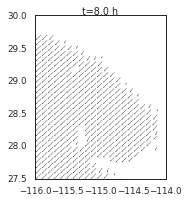

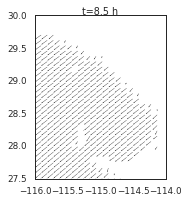

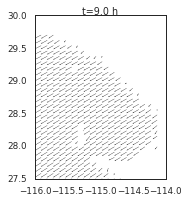

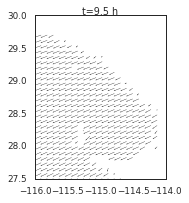

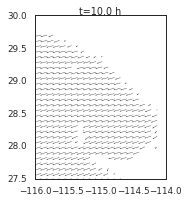

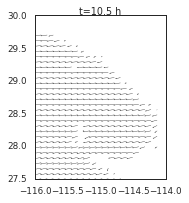

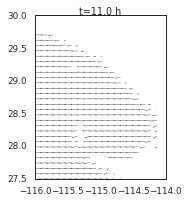

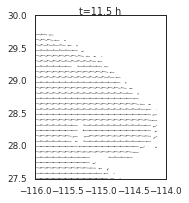

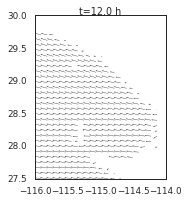

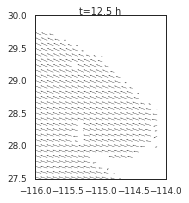

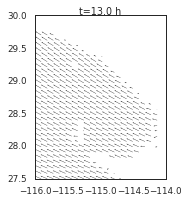

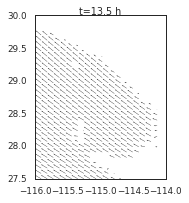

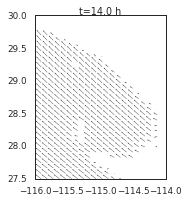

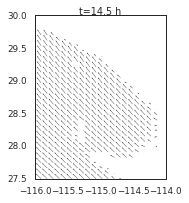

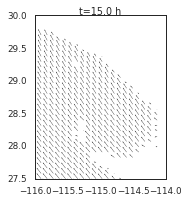

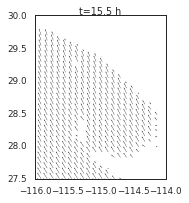

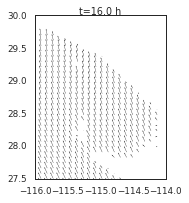

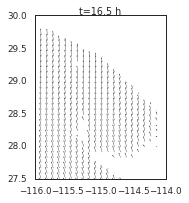

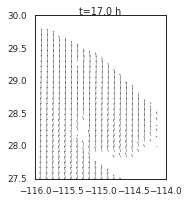

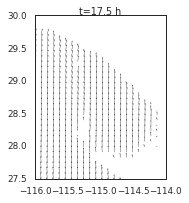

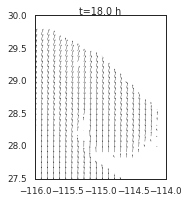

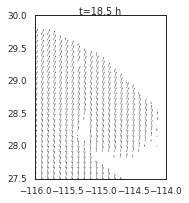

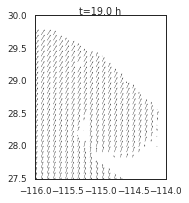

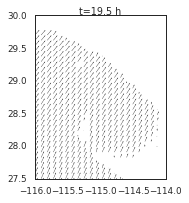

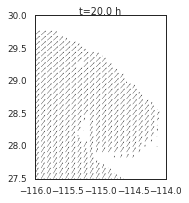

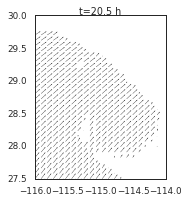

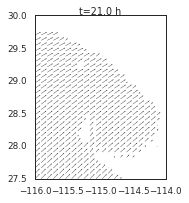

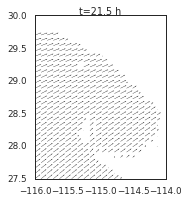

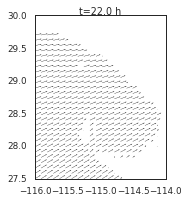

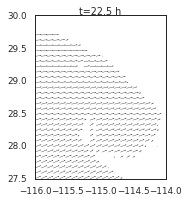

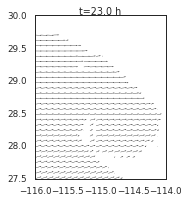

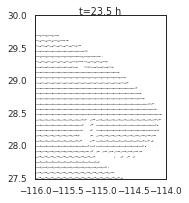

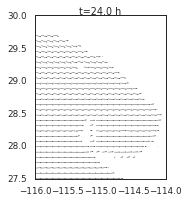

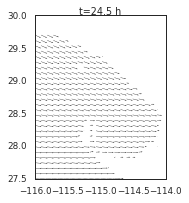

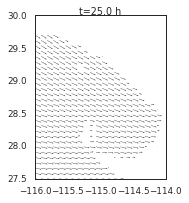

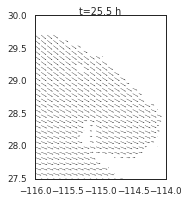

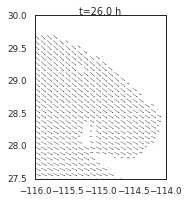

In [38]:
sp = 6  
llon, llat = np.meshgrid(lon,lat)

for tt in range(48, 79*2, 3):
    uu = ds['UVEL'][tt,0,:200,300:].data
    vv = ds['VVEL'][tt,0,:200,300:].data
    #u, v = unstagger(uu,vv)
    fig,ax = plt.subplots(1,1, figsize=(3,3))
    ax.quiver(llon[:200:sp,300::sp],llat[:200:sp,300::sp],
              np.ma.masked_array(uu, mask=mask[0,:200,300:])[::sp,::sp],
              np.ma.masked_array(vv, mask=mask[0,:200,300:])[::sp,::sp],
              scale=3)
    ax.set_aspect(1)
    ax.set_xlim(-116, -114)
    ax.set_ylim(27.5, 30)
    ax.set_title('t=%1.1f h'%(time[tt]/3600), pad=0.3)
    plt.show()

In [94]:
#uu = np.zeros(720)
#vv = np.zeros(720)

for tt in range(75,720):
    uu[tt] = ds['UVEL'][tt,0,lat_inds[0],lon_inds[0]].data
    vv[tt] = ds['VVEL'][tt,0,lat_inds[0],lon_inds[0]].data
    print(tt)

75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


ValueError: setting an array element with a sequence.

ValueError: dimensions () must have the same length as the number of data dimensions, ndim=1

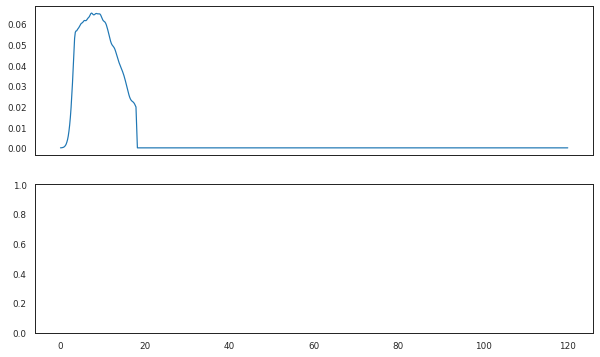

In [97]:
ssh = ds['ETAN'][:,lat_inds[0],lon_inds[0]].data
time2 = np.arange(1,721)*600
g = 9.81
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)
    
ax1.plot(time2/3600, np.sqrt(uu**2+vv**2)/2)
ax2.plot(time/3600,  g*(ssh[:720]+np.ones_like(ssh[:720])*depth[lat_inds[0],lon_inds[0]]))
ax1.axvline(3.5, color='k')
ax2.axvline(3.5, color='k')
ax1.set_xlim(0,60)
plt.show()

In [84]:
time2

array([     0,    600,   1200,   1800,   2400,   3000,   3600,   4200,
         4800,   5400,   6000,   6600,   7200,   7800,   8400,   9000,
         9600,  10200,  10800,  11400,  12000,  12600,  13200,  13800,
        14400,  15000,  15600,  16200,  16800,  17400,  18000,  18600,
        19200,  19800,  20400,  21000,  21600,  22200,  22800,  23400,
        24000,  24600,  25200,  25800,  26400,  27000,  27600,  28200,
        28800,  29400,  30000,  30600,  31200,  31800,  32400,  33000,
        33600,  34200,  34800,  35400,  36000,  36600,  37200,  37800,
        38400,  39000,  39600,  40200,  40800,  41400,  42000,  42600,
        43200,  43800,  44400,  45000,  45600,  46200,  46800,  47400,
        48000,  48600,  49200,  49800,  50400,  51000,  51600,  52200,
        52800,  53400,  54000,  54600,  55200,  55800,  56400,  57000,
        57600,  58200,  58800,  59400,  60000,  60600,  61200,  61800,
        62400,  63000,  63600,  64200,  64800,  65400,  66000,  66600,
      

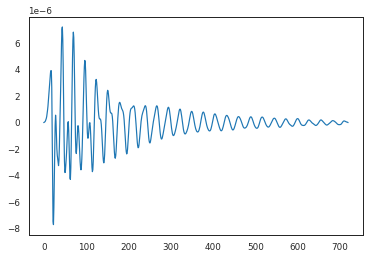

In [70]:
plt.plot((((ssh[2:722]-ssh[:720])/1200)))

In [28]:
np.shape(np.ma.masked_array(uu, mask=mask[0,:200,300:])[::5])

(40, 212)